In [24]:
%matplotlib inline

import json
import os
import pickle
import numpy as np
import random
import matplotlib.image as mpimg
import cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

import pandas

import copy

from keras.models import Model
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.layers import Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from pandas.io.parsers import read_csv

In [25]:
print("modules loaded")

modules loaded


In [26]:
"""
create new data by duplicating existing images by perturbing the angles a bit.
"""
#Credit
#https://medium.com/@acflippo/cloning-driving-behavior-by-augmenting-steering-angles-5faf7ea8a125#.41vw9spjy
def perturb_angle(angle):
    new_angle = angle* (1 + np.random.uniform(-1, 1)/30.0)
    return min(1, new_angle) if new_angle > 0 else max(-1, new_angle)

def draw_data_hist(data, header):
    plt.figure()
    print(header,"max value is", max(data))
    print(header,"min value is", min(data))
    unique_values, counts = np.unique(data, return_counts=True)
    plt.hist(data, bins=min(len(counts), 100))
    plt.title(header)
    plt.axis([min(data), max(data), 0, max(counts)]);

In [27]:
#LOAD and MODIFY data
drive_info = read_csv("data/driving_log.csv", header=0, usecols=[0,1,2,3]).as_matrix();

modified_data = []
for row in drive_info:
    center = copy.deepcopy(row)
    center[1] = row[3] #original_angle
    modified_data.append(center)

    left = copy.deepcopy(row)
    left[0] = left[1] #left_image
    left[1] = left[3]+0.25
    modified_data.append(left)
    
    right = copy.deepcopy(row)
    right[0] = right[2] #right image
    right[1] = right[3]-0.25
    modified_data.append(right)

# add more samples for steering angle more than 0.5 or less then -0.5

insufficient_data = [data for data in modified_data if abs(float(data[3])) > 0.5]
for line in insufficient_data:
    for i in range(0, 14):
        new_line = copy.deepcopy(line)
        new_line[1] = perturb_angle(line[3])
        modified_data.append(new_line)

driving_data = np.array(modified_data)    
print('modified data', len(modified_data))


modified data 25956


(8036, 7)


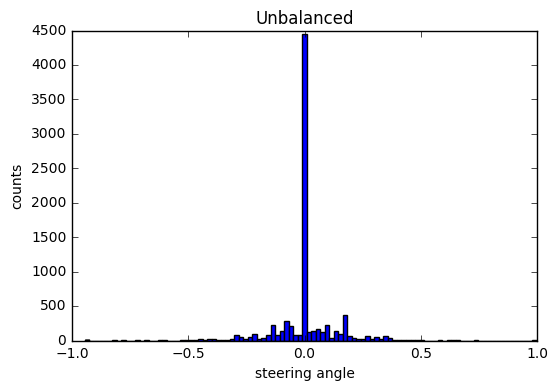

In [18]:
dir = "data"
with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
    data = pandas.read_csv(f, header=0, skipinitialspace=True).values
    print(data.shape)
plt.hist(data[:,3], bins=100)
plt.title('Unbalanced')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

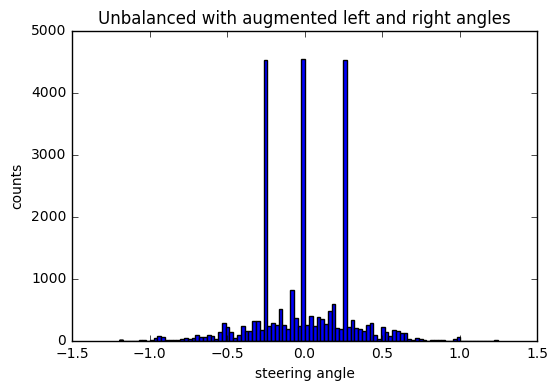

In [34]:
plt.hist(driving_data[:,1], bins=100)
plt.title('Unbalanced with augmented left and right angles')
plt.xlabel('steering angle')
plt.ylabel('counts')
plt.show()

In [36]:
training_data=[]
validation_data=[]

step = 0.01
per_step = 19
current_bin = 0.0

"""
Utility method to extract data from bin
"""
def extract_data_from_bin(current_bin_data):
    validation_bin = []
    
    if len(current_bin_data) > per_step:
        current_bin_data = shuffle(current_bin_data)
        validation_bin = current_bin_data[per_step:2*per_step]
        for line in validation_bin:
            validation_data.append(line)
        current_bin_data = current_bin_data[0:per_step]
    for line in current_bin_data:
        training_data.append(line)

In [37]:
#
sample_bin_start = 0.0
sample_bin_end = 1.0
sample_bin_step = 0.01
current_bin_data = []
    
while current_bin<sample_bin_end:
    current_bin_data = [data for data in modified_data if (current_bin < abs(data[1])) and (abs(data[1])<=current_bin+step)]
    extract_data_from_bin(current_bin_data)
    #print("bin:len", current_bin, " : ", len(current_bin_data) )
    current_bin = current_bin+step
        
zero_bin = [data for data in modified_data if (data[1]==0.0)]
extract_data_from_bin(zero_bin)

training_data = np.array(training_data)
validation_data = np.array(validation_data)
        
#draw_data_hist(abs(training_data[:,1]), 'train angles');
#draw_data_hist(abs(validation_data[:,1]), 'validation angles');

print("trained data", len(training_data))
print("validation data", len(validation_data))


trained data 1736
validation data 1448


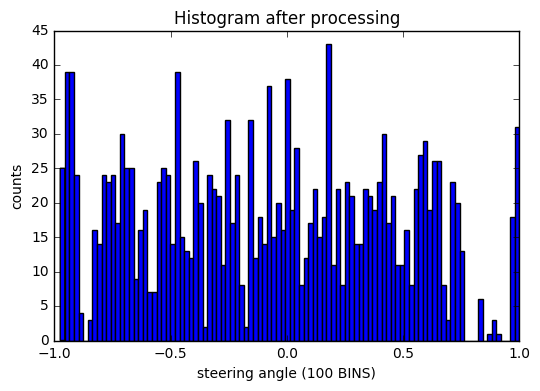

In [38]:
plt.hist(training_data[:,1], bins=100)
plt.title('Histogram after processing')
plt.xlabel('steering angle (100 BINS)')
plt.ylabel('counts')
plt.show()

In [39]:
# prepare data to save

pickle_data = []
validation_pickle = []

for row in training_data:  
    pickle_data.append({ 'center': row[0], 'angle': row[1] })
    
for row in validation_data:  
    validation_pickle.append({ 'center': row[0], 'angle': row[1] })
    
training_file = 'train.p'
with open("data/"+training_file, 'wb') as handle:
    pickle.dump(np.array(pickle_data), handle, protocol=pickle.HIGHEST_PROTOCOL)
    
validation_file = 'validation.p'
with open("data/"+validation_file, 'wb') as handle:
    pickle.dump(np.array(validation_pickle), handle, protocol=pickle.HIGHEST_PROTOCOL)

print("Training and validation angles saved to pickle file")

Training and validation angles saved to pickle file


In [40]:
"""
IMAGE PRE-PROCESSING TECHNIQUES
"""
def img_pre_process(image):
    roi = image[60:140, :, :] #Cut top and bottom of image
    image = cv2.resize(roi, (64,64), interpolation=cv2.INTER_AREA) #reducing image size so that model runs faster
    return image

#Image brigtness method
#Credit: https://github.com/mohankarthik/CarND-BehavioralCloning-P3/blob/master/model.py
def img_change_brightness(img):
    # Convert the image to HSV
    temp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Compute a random brightness value and apply to the image
    brightness = 0.25 + np.random.uniform()
    temp[:, :, 2] = temp[:, :, 2] * brightness

    # Convert back to RGB and return
    return cv2.cvtColor(temp, cv2.COLOR_HSV2RGB)

#translate image and compensate for the translation on the steering angle
def translate_image(image, steering, horz_range=30, vert_range=5):
    rows, cols, chs = image.shape
    tx = np.random.randint(-horz_range, horz_range+1)
    ty = np.random.randint(-vert_range, vert_range+1)
    steering = steering + tx * 0.004 # multiply by steering angle units per pixel
    tr_M = np.float32([[1,0,tx], [0,1,ty]])
    image = cv2.warpAffine(image, tr_M, (cols,rows), borderMode=1)
    return image, steering


In [41]:
FOLDER_PATH = 'data'

def read_image(image_path):
    full_image_path = os.path.join(FOLDER_PATH, image_path.strip())
    image = mpimg.imread(full_image_path)
    return img_pre_process(image)

# flipping, to avoid bias to left\right turns
# brightness, augmentaion to generalize to t2
# translate, to simulate the car being at the edges of the road and hill-slopes
# translate is done both on normal and flipped images
def generate_steering_angle(data, batch_size=128):
    X = []
    Y = []
    while True:
        data = shuffle(data)    
        for line in data:
            image = read_image(line['center'])
            angle = line['angle']
            image_brightened = img_change_brightness(image)
            X.append(image_brightened)
            Y.append(angle)
            
            flipped_image = cv2.flip(image, 1)
            flipped_image_brightened = img_change_brightness(flipped_image)
            X.append(flipped_image_brightened)
            Y.append(-angle)
            
            translated_image, translated_angle = translate_image(image_brightened, angle)
            X.append(translated_image)
            Y.append(translated_angle)

            translated_flipped_image, translated_flipped_angle = translate_image(flipped_image_brightened, angle)
            X.append(translated_flipped_image)
            Y.append(translated_flipped_angle)

            if len(X)>=batch_size:
                X, Y = shuffle(X, Y)
                yield np.array(X), np.array(Y) # (image, steering angle)
                X=[]
                Y=[]
            

def generate_validation(data):
    X = []
    Y = []
    while True:
        data = shuffle(data)
        for line in data:
            angle = line['angle']
            image = read_image(line['center'])

            X.append(image)
            Y.append(angle)
            yield np.array(X), np.array(Y) # (image, steering angle)
            

In [42]:
def create_model():
    # create the base pre-trained model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=[64, 64, 3])

    x = base_model.output
    x = Flatten()(x)

    # and a regression layer to predict steering angle
    x = Dense(1000, activation='relu', name='fc1', W_regularizer=l2(0.0001))(x)
    #x = Dropout(0.5)(x)
    x = Dense(250, activation='relu', name='fc2', W_regularizer=l2(0.0001))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1)(x)

    model = Model(input=base_model.input, output=predictions)
    # train only the top layers (which were randomly initialized)
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [11]:
model = create_model()

training_pickle = 'data/train.p'
with open(training_pickle, 'rb') as handle:
    driving_info = pickle.load(handle)

validation_pickle = 'data/validation.p'
with open(validation_pickle, 'rb') as handle:
    validation_info = pickle.load(handle)
    
print("train size", len(driving_info))
print("validation size", len(validation_info))

# train the model on the new data for a few epochs
model.fit_generator(
    generate_steering_angle(driving_info, batch_size=32),
    samples_per_epoch=len(driving_info)*4, 
    nb_epoch=5,
    validation_data=generate_validation(validation_info),
    nb_val_samples=len(validation_info)/7)

train size 1733
validation size 1440
Epoch 1/5
6912/6932 [============================>.] - ETA: 0s - loss: 82.1391

/Users/khaleel.pasha/anaconda/envs/selfDrivingCarCourseEnvironment/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6944/6932 [==============================] - 301s - loss: 81.7619 - val_loss: 0.3844
Epoch 2/5
6944/6932 [==============================] - 309s - loss: 0.4340 - val_loss: 0.3619
Epoch 3/5
6944/6932 [==============================] - 316s - loss: 0.4142 - val_loss: 0.3119
Epoch 4/5
6944/6932 [==============================] - 304s - loss: 0.4022 - val_loss: 0.2905
Epoch 5/5
6944/6932 [==============================] - 1933s - loss: 0.3824 - val_loss: 0.2594


In [31]:
#Save the model
model_json = 'model.json'
model_weights = 'model.h5'

json_string = model.to_json()
try:
    os.remove(model_json)
    os.remove(model_weights)
except OSError:
    pass

with open(model_json, 'w') as jfile:
    json.dump(json_string, jfile)
model.save(model_weights)

print("model saved.")

model is saved
